# ECE 1513 Project: Predicting Real Estate Prices in the Greater Toronto Area

## Import Libraries

In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.kernel_approximation import Nystroem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load and Preprocess Dataset

In [17]:
# Load data
path = '/Users/zactseng/Documents/ECE 1513/Project/GTA-Real-Estate-Price-Prediction/clean_combined_toronto_property_data.xlsx'
data = pd.read_excel(path)

# Handle extreme outliers in price
upper_limit = data["price"].mean() + 3 * data["price"].std()
lower_limit = data["price"].mean() - 3 * data["price"].std()
data = data[(data["price"] >= lower_limit) & (data["price"] <= upper_limit)]

# Add new features
data["price_per_bedroom"] = data["pricem"] / data["bedrooms"].replace(0, np.nan)
data["price_per_bathroom"] = data["pricem"] / data["bathrooms"].replace(0, np.nan)

# Fill NaN values caused by zero bedrooms or bathrooms
data["price_per_bedroom"] = data["price_per_bedroom"].fillna(0)
data["price_per_bathroom"] = data["price_per_bathroom"].fillna(0)

# Normalize new features to reduce the effect of extreme values
data["price_per_bedroom"] = (data["price_per_bedroom"] - data["price_per_bedroom"].mean()) / data["price_per_bedroom"].std()
data["price_per_bathroom"] = (data["price_per_bathroom"] - data["price_per_bathroom"].mean()) / data["price_per_bathroom"].std()

# Define features and target
X = data[["region", "bedrooms", "bathrooms", "price_per_bedroom", "price_per_bathroom"]]
y = data["pricem"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), ["region"])
    ],
    remainder="passthrough"
)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Gradient Boosting Regression

In [18]:
gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler()),
    ("model", GradientBoostingRegressor(random_state=42))
])

# Hyperparameter tuning with GridSearchCV
param_grid_gb = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.05, 0.1, 0.2],
    "model__max_depth": [3, 5, 7]
}

grid_search_gb = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=param_grid_gb,
    scoring="r2",
    n_iter=10,
    cv=5,
    n_jobs=-1
)

# Fit the model
grid_search_gb.fit(X_train, y_train)

# Evaluate Gradient Boosting
best_model_gb = grid_search_gb.best_estimator_
gb_predictions = best_model_gb.predict(X_test)
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)
print(f"Gradient Boosting - MSE: {gb_mse:.4f}, R2: {gb_r2:.4f}")

Gradient Boosting - MSE: 0.0083, R2: 0.9863


## Polynomial Regression

In [19]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
poly_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("poly", poly_features),
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Fit the Polynomial Regression model
poly_pipeline.fit(X_train, y_train)

# Evaluate Polynomial Regression
poly_predictions = poly_pipeline.predict(X_test)
poly_mse = mean_squared_error(y_test, poly_predictions)
poly_r2 = r2_score(y_test, poly_predictions)
print(f"Polynomial Regression - MSE: {poly_mse:.4f}, R2: {poly_r2:.4f}")

Polynomial Regression - MSE: 0.0167, R2: 0.9724


## Optimized SVM Regression

In [20]:
# Use Nystroem kernel approximation for RBF kernel
nystroem = Nystroem(kernel="rbf", n_components=100)

svm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("nystroem", nystroem),  # Approximation
    ("scaler", StandardScaler()),
    ("model", SVR())
])

# Hyperparameter tuning for SVM with RandomizedSearchCV
param_grid_svm = {
    "model__C": [0.1, 1, 10],
    "model__epsilon": [0.01, 0.1, 0.5]
}

random_search_svm = RandomizedSearchCV(
    svm_pipeline,
    param_distributions=param_grid_svm,
    scoring="r2",
    n_iter=10,
    cv=5,
    n_jobs=-1
)

# Randomly sample 10% of the training data for faster optimization
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

# Fit the model
random_search_svm.fit(X_train_sample, y_train_sample)

# Evaluate SVM Regression
best_model_svm = random_search_svm.best_estimator_
svm_predictions = best_model_svm.predict(X_test)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)
print(f"Optimized SVM Regression - MSE: {svm_mse:.4f}, R2: {svm_r2:.4f}")

/Users/zactseng/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Optimized SVM Regression - MSE: 0.0276, R2: 0.9544


/Users/zactseng/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Visualizations

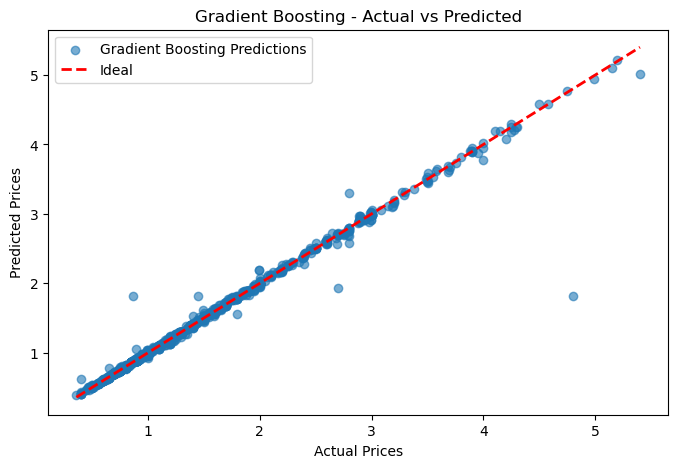

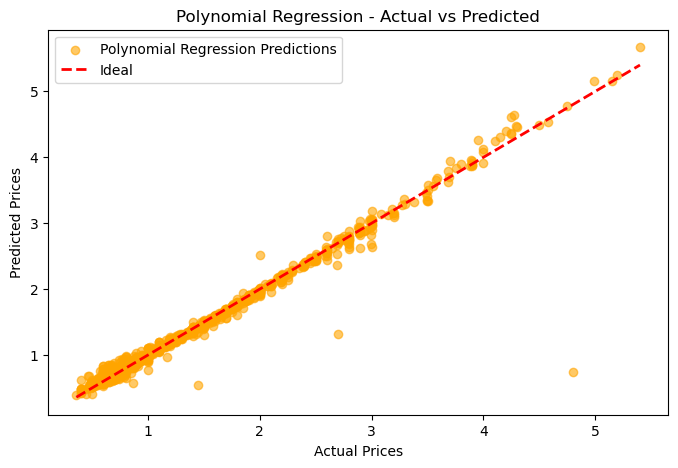

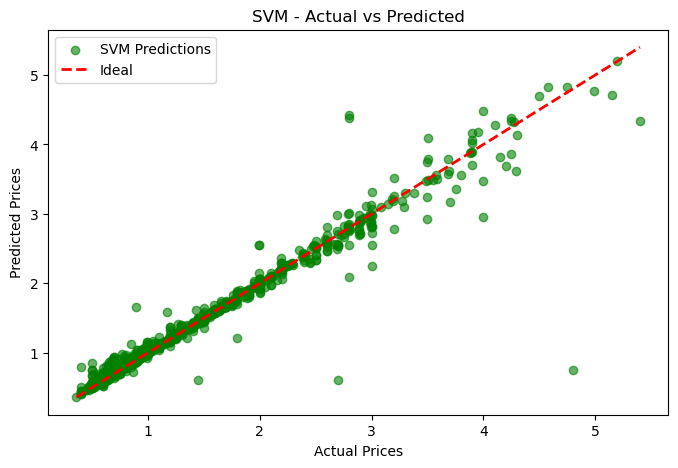

Comparison of Actual and Predicted Prices:
   Actual Price  Gradient Boosting Prediction  \
0         1.889                         1.888   
1         1.000                         0.924   
2         2.799                         2.796   
3         1.479                         1.474   
4         0.560                         0.554   
5         1.450                         1.816   
6         0.900                         0.907   
7         4.300                         4.249   
8         2.499                         2.503   
9         0.749                         0.743   

   Polynomial Regression Prediction  SVM Prediction  
0                             1.847           1.832  
1                             0.891           1.104  
2                             2.808           2.769  
3                             1.462           1.476  
4                             0.652           0.602  
5                             0.545           0.606  
6                             0.877    

In [21]:
# Gradient Boosting Predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, gb_predictions, alpha=0.6, label="Gradient Boosting Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal")
plt.title("Gradient Boosting - Actual vs Predicted")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()

# Polynomial Regression Predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, poly_predictions, alpha=0.6, label="Polynomial Regression Predictions", color="orange")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal")
plt.title("Polynomial Regression - Actual vs Predicted")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()

# SVM Predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_test, svm_predictions, alpha=0.6, label="SVM Predictions", color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ideal")
plt.title("SVM - Actual vs Predicted")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.legend()
plt.show()

# Create a DataFrame to compare predictions with actual values
comparison_df = pd.DataFrame({
    "Actual Price": y_test.values[:10],  # Select the first 10 samples
    "Gradient Boosting Prediction": gb_predictions[:10],
    "Polynomial Regression Prediction": poly_predictions[:10],
    "SVM Prediction": svm_predictions[:10]
})

# Round the values for better readability
comparison_df = comparison_df.round(3)

# Print the table
print("Comparison of Actual and Predicted Prices:")
print(comparison_df)